In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
from statsmodels.regression.rolling import RollingOLS

In [3]:
raw = pd.read_excel("../data/raw.xlsx")
raw

## Calculate the FCFROIC rate
## Calculate the ROE for financial company

In [31]:
raw.columns

Index(['Global Company Key', 'Data Date', 'Fiscal Year', 'Fiscal Quarter',
       'Fiscal Year-end Month', 'Industry Format',
       'Level of Consolidation - Company Interim Descriptor',
       'Population Source', 'Data Format', 'Ticker Symbol', 'Company Name',
       'ISO Currency Code', 'Calendar Data Year and Quarter',
       'Fiscal Data Year and Quarter', 'Assets - Total',
       'Invested Capital - Total - Quarterly', 'Net Income (Loss)',
       'Stockholders Equity - Total', 'Capital Expenditures',
       'Operating Activities - Net Cash Flow', 'Active/Inactive Status Marker',
       'Standard Industry Classification Code'],
      dtype='object')

In [32]:
raw["pre_IC"] = raw["Invested Capital - Total - Quarterly"].shift()
raw["ave_IC"] = (raw["Invested Capital - Total - Quarterly"] + raw["pre_IC"]) * 1/2

# for companies which do not have Capital Expenditures: nan --> 0
raw[raw['Capital Expenditures'] == np.nan] = 0
raw["FCF"] = raw['Operating Activities - Net Cash Flow'] - raw['Capital Expenditures']
raw["FCFROIC"] = raw["FCF"]/raw["ave_IC"]

# for those finance service companies
raw["ave_equity"] = (raw["Stockholders Equity - Total"] + raw["Stockholders Equity - Total"].shift()) * 1/2
raw["ave_asset"] = (raw['Assets - Total'] + raw['Assets - Total'].shift()) * 1/2
raw["ROA"] = raw["Net Income (Loss)"]/raw["ave_asset"]
raw["ROE"] = raw["Net Income (Loss)"]/raw["ave_equity"]

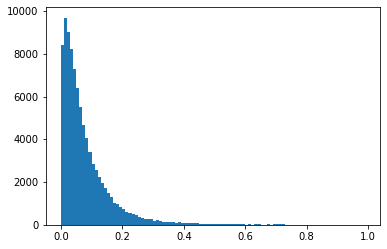

In [27]:
num = raw["FCFROIC"].dropna()
plt.hist(num, bins=np.arange(0, 1, 0.01))
plt.show()

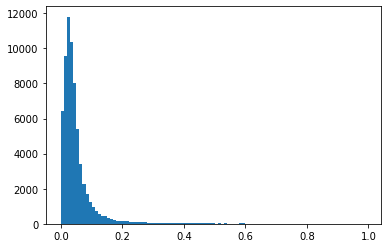

In [34]:
num = raw["ROE"].dropna()
plt.hist(num, bins=np.arange(0, 1, 0.01))
plt.show()

In [40]:
# 6000-6411
raw['SIC'] = raw['Standard Industry Classification Code'].astype(int)
raw["FCFROIC_ADJ"] = raw["FCFROIC"]
raw[(raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["FCFROIC_ADJ"] = raw[(
    raw['SIC'] >= 6000) & (raw["SIC"] <= 6411)]["ROE"]

In [41]:
raw.iloc[1:][["Global Company Key", "Data Date",
             "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
             "ROA", "ROE", "FCFROIC_ADJ"]]


,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ
1,1045,1963-06-30 00:00:00,1963,2.0,AAL,NaN,NaN,NaN,NaN
2,1045,1963-09-30 00:00:00,1963,3.0,AAL,NaN,NaN,NaN,NaN
3,1045,1963-12-31 00:00:00,1963,4.0,AAL,NaN,NaN,NaN,NaN
4,1045,1964-03-31 00:00:00,1964,1.0,AAL,NaN,NaN,NaN,NaN
5,1045,1964-06-30 00:00:00,1964,2.0,AAL,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
184254,328795,2021-06-30 00:00:00,2021,2.0,ACA,0.004033,0.007227,0.010857,0.004033
184255,328795,2021-09-30 00:00:00,2021,3.0,ACA,0.006054,0.007416,0.012275,0.006054
184256,328795,2021-12-31 00:00:00,2021,4.0,ACA,0.030491,0.002835,0.004725,0.030491
184257,328795,2022-03-31 00:00:00,2022,1.0,ACA,-0.000528,0.006269,0.010278,-0.000528


In [53]:
grouped = raw.groupby('Global Company Key')
FCFROIC_ADJ = pd.DataFrame(columns=["Global Company Key", "Data Date",
                                    "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC",
                                    "ROA", "ROE", "FCFROIC_ADJ"])
for group in grouped:
    group = group[1].iloc[1:][["Global Company Key", "Data Date",
                   "Fiscal Year", "Fiscal Quarter", 'Ticker Symbol', "FCFROIC", 
                   "ROA", "ROE", "FCFROIC_ADJ"]].copy()
    FCFROIC_ADJ = FCFROIC_ADJ.append(group, ignore_index=True)

In [55]:
FCFROIC_ADJ.to_excel("../data/FCFROIC_ADJ.xlsx", index=False)

## Calculate beta

In [245]:
close_price = pd.read_excel("../data/stock_returns.xlsx")
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315
...,...,...,...,...,...,...
656935,TSLA,2021-11-30,1144.760,2021-11-30,1114.000,0.027612
656936,TSLA,2021-12-31,1056.780,2021-12-31,1144.760,-0.076855
656937,TSLA,2022-01-31,936.720,2022-01-31,1056.780,-0.113609
656938,TSLA,2022-02-28,870.430,2022-02-28,936.720,-0.070768


In [248]:
close_price["q_pre_p"] = close_price["Monthly Price"].shift(3)
close_price["q_ret"] = close_price["Monthly Price"] / \
    close_price["q_pre_p"] - 1
close_price

,Ticker,Monthly Calendar Date,Monthly Price,Monthly Price Date,Monthly Previous Price,Monthly Total Return,q_pre_p,q_ret
0,ACF,1961-01-31,50.250,1961-01-31,38.000,0.322368,NaN,NaN
1,ACF,1961-02-28,50.375,1961-02-28,50.250,0.014743,NaN,NaN
2,ACF,1961-03-30,54.750,1961-03-30,50.375,0.086849,NaN,NaN
3,ACF,1961-04-28,56.000,1961-04-28,54.750,0.022831,50.250,0.114428
4,ACF,1961-05-31,59.750,1961-05-31,56.000,0.078315,50.375,0.186104
...,...,...,...,...,...,...,...,...
656935,TSLA,2021-11-30,1144.760,2021-11-30,1114.000,0.027612,735.720,0.555972
656936,TSLA,2021-12-31,1056.780,2021-12-31,1144.760,-0.076855,775.480,0.362743
656937,TSLA,2022-01-31,936.720,2022-01-31,1056.780,-0.113609,1114.000,-0.159138
656938,TSLA,2022-02-28,870.430,2022-02-28,936.720,-0.070768,1144.760,-0.239640


In [35]:
close_price = close_price[close_price["Monthly Price Date"] >= datetime.strptime("1979-01-31", "%Y-%m-%d")]

In [40]:
close_price.index = close_price["Monthly Price Date"]

In [48]:
close_price["pct_chg_excess"] = close_price["Monthly Total Return"]*100 - 0.5

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_15049/1112876321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_price["pct_chg_excess"] = close_price["Monthly Total Return"]*100 - 0.5


In [51]:
close_price_u = close_price[["Ticker", "pct_chg_excess"]].copy()
cp_grouped = close_price_u.groupby("Ticker")

In [15]:
RMID = pd.read_excel("../data/PriceHistory.xlsx", index_col=0)
RMID.head()

,Price,CVol,Change,% Change,"Total Return (Gross, Unhedged)","Cumulative Return % (Gross, Unhedged)",Open,High,Low
Date,,,,,,,,,
1979-01-31,105.996,NaN,5.996,5.996000,106.250,6.250,NaN,105.996,105.996
1979-02-28,102.385,NaN,-3.611,-3.406732,103.201,3.201,NaN,102.385,102.385
1979-03-30,110.369,NaN,7.984,7.798017,111.715,11.715,NaN,110.369,110.369
1979-04-30,111.249,NaN,0.880,0.797325,112.910,12.910,NaN,111.249,111.249
1979-05-31,109.688,NaN,-1.561,-1.403159,111.984,11.984,NaN,109.688,109.688


In [52]:
RMID["excess_ret"] = RMID["Change"] - 0.5

In [114]:
x = RMID["excess_ret"]
group = close_price[close_price["Ticker"] == "ACF"]
ECoC = pd.DataFrame()
ls = []
for group in cp_grouped:
    name = group[0]
    y = group[1].copy()
    y = y[["pct_chg_excess"]]
    xy = y.merge(x, left_index=True, right_index=True, how="inner")
    if xy.shape[0] > 60:
        rols = RollingOLS(xy.iloc[:, 0], xy.iloc[:, 1], window=60).fit()
        params = rols.params * xy[["excess_ret"]] + 0.5
        params["name"] = name
        ls.append(params.dropna())
ECoC = pd.concat(ls)
ECoC

,excess_ret,name
1984-01-31,-6.826041,A
1984-03-30,2.576142,A
1984-04-30,-2.646795,A
1984-05-31,-11.702502,A
1984-06-29,5.073839,A
...,...,...
2021-11-30,-2.723452,ZTS
2021-12-31,3.974931,ZTS
2022-01-31,-7.119006,ZTS
2022-02-28,-0.334841,ZTS


In [115]:
ECoC.to_excel("../clean_data/ECoC.xlsx")

In [120]:
ECoC

,excess_ret,name,10y_avg
1984-01-31,-6.826041,A,NaN
1984-03-30,2.576142,A,NaN
1984-04-30,-2.646795,A,NaN
1984-05-31,-11.702502,A,NaN
1984-06-29,5.073839,A,NaN
...,...,...,...
2021-11-30,-2.723452,ZTS,1.818128
2021-12-31,3.974931,ZTS,1.689975
2022-01-31,-7.119006,ZTS,1.483275
2022-02-28,-0.334841,ZTS,1.416325


In [126]:
grouped = ECoC.groupby("name")

ls = []
for group in grouped:
    name = group[0]
    group = group[1]
    if group.shape[0] > 120:
        group["10y_avg"] = group["excess_ret"].rolling(120).mean()
        group["name"] = name
        ls.append(group.dropna())
ave_ecoc = pd.concat(ls)

In [128]:
ave_ecoc.to_excel("../clean_data/ave_ecoc.xlsx")

In [189]:
ave_ecoc["annualized"] = ave_ecoc["10y_avg"] * 12 / 100
ave_ecoc

,excess_ret,name,10y_avg,annualized
1990-10-31,-3.264118,A,1.799868,0.215984
1990-11-30,9.547320,A,1.936313,0.232358
1990-11-30,9.366970,A,1.992903,0.239148
1990-12-31,4.643537,A,2.053656,0.246439
1991-01-31,7.467436,A,2.213405,0.265609
...,...,...,...,...
2013-12-31,14.285007,ZLC,3.002298,0.360276
2014-01-31,-9.244454,ZLC,2.877273,0.345273
2014-02-28,29.049326,ZLC,3.083022,0.369963
2014-03-31,-1.828388,ZLC,3.066126,0.367935


In [132]:
date_idx = ave_ecoc.index.drop_duplicates()
date_idx = date_idx.sort_values()
date_idx

DatetimeIndex(['1980-04-30', '1980-05-30', '1980-06-30', '1980-07-31',
               '1980-08-29', '1980-09-30', '1980-10-31', '1980-11-28',
               '1980-12-31', '1981-01-30',
               ...
               '2021-06-30', '2021-07-30', '2021-08-31', '2021-09-30',
               '2021-10-29', '2021-11-30', '2021-12-31', '2022-01-31',
               '2022-02-28', '2022-03-31'],
              dtype='datetime64[ns]', length=504, freq=None)

## Calculate high and low quality

In [143]:
his_members = pd.read_excel("../data/members.xlsx", sheet_name=1)
his_members

,1980-03-31,1980-06-30,1980-09-30,1980-12-31,1981-03-31,1981-06-30,1981-09-30,1981-12-31,1982-03-31,1982-06-30,...,2020-09-30,2020-12-31,2021-03-31,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-10-20
0,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,0111145D UN Equity,...,1981718D UW Equity,2061517D UW Equity,2061517D UW Equity,2150994D UW Equity,2150994D UW Equity,1950546D US Equity,2150994D UW Equity,2150994D UW Equity,A UN Equity,A UN Equity
1,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,0118113D UN Equity,...,2061517D UW Equity,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,2150994D UW Equity,9990213D UN Equity,9990213D UN Equity,AA UN Equity,AA UN Equity
2,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,0203524D UN Equity,...,2078185D UN Equity,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990253D UN Equity,9990213D UN Equity,9990253D UN Equity,A UN Equity,AAL UW Equity,AAL UW Equity
3,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,0226226D UN Equity,...,2150994D UW Equity,9990213D UN Equity,9990253D UN Equity,9990527D UW Equity,9990527D UW Equity,9990253D UN Equity,9990527D UW Equity,AA UN Equity,AAP UN Equity,AAP UN Equity
4,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,0544749D UN Equity,...,9990213D UN Equity,9990253D UN Equity,9990620D UN Equity,A UN Equity,A UN Equity,9990527D UW Equity,A UN Equity,AAL UW Equity,ACGL UW Equity,ACGL UW Equity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZBH UN Equity,NaN,NaN,ZION UW Equity,NaN,ZBRA UW Equity,NaN,NaN
703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZBRA UW Equity,NaN,NaN,ZNGA UW Equity,NaN,ZG UW Equity,NaN,NaN
704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZG UW Equity,NaN,NaN,NaN,NaN,ZION UW Equity,NaN,NaN
705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,ZION UW Equity,NaN,NaN,NaN,NaN,ZM UW Equity,NaN,NaN


In [145]:
FCFROIC_ADJ = pd.read_excel("../data/FCFROIC_ADJ.xlsx")
FCFROIC_ADJ

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ
0,1045,1963-06-30,1963,2.0,AAL,NaN,NaN,NaN,NaN
1,1045,1963-09-30,1963,3.0,AAL,NaN,NaN,NaN,NaN
2,1045,1963-12-31,1963,4.0,AAL,NaN,NaN,NaN,NaN
3,1045,1964-03-31,1964,1.0,AAL,NaN,NaN,NaN,NaN
4,1045,1964-06-30,1964,2.0,AAL,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
182593,328795,2021-06-30,2021,2.0,ACA,0.004033,0.007227,0.010857,0.004033
182594,328795,2021-09-30,2021,3.0,ACA,0.006054,0.007416,0.012275,0.006054
182595,328795,2021-12-31,2021,4.0,ACA,0.030491,0.002835,0.004725,0.030491
182596,328795,2022-03-31,2022,1.0,ACA,-0.000528,0.006269,0.010278,-0.000528


In [156]:
test = FCFROIC_ADJ[(FCFROIC_ADJ["Fiscal Year"] == 1980) & (FCFROIC_ADJ["Fiscal Quarter"] == 1)]

In [174]:
FCFROIC_ADJ[FCFROIC_ADJ["Data Date"] == "1990-03-31"].dropna(subset=['FCFROIC_ADJ'])


,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ
107,1045,1990-03-31,1990,1.0,AAL,-0.099614,-0.001709,-0.005138,-0.099614
733,1161,1990-03-31,1990,1.0,AMD,-0.058428,0.011632,NaN,-0.058428
1037,1177,1990-03-31,1990,1.0,AET,-0.008152,0.002064,NaN,-0.008152
1256,1209,1990-03-31,1990,2.0,APD,-0.005788,0.016995,NaN,-0.005788
1481,1230,1990-03-31,1990,1.0,ALK,-0.094485,-0.002369,NaN,-0.094485
...,...,...,...,...,...,...,...,...,...
114969,20993,1990-03-31,1990,1.0,VRC,0.023404,-0.009305,NaN,0.023404
116725,22815,1990-03-31,1990,1.0,TRMB,0.157897,0.001459,NaN,0.157897
117403,23252,1990-03-31,1990,3.0,ETD,0.036445,-0.009506,NaN,0.036445
119775,24363,1990-03-31,1990,1.0,BUCY,-0.165823,-0.016891,NaN,-0.165823


In [151]:
fcfroic_grouped = FCFROIC_ADJ.groupby("Data Date")

In [198]:
q_ls = his_members.columns

i = 40

ls = []

for i in range(his_members.shape[1]-1):
    m = his_members.iloc[:, i].dropna()
    g = FCFROIC_ADJ[FCFROIC_ADJ["Data Date"] == m.name]

    m = m.str.extract(r'(\w+)')[0].values
    subset = g[g["Ticker Symbol"].isin(m)]
    subset = subset.dropna(subset=["FCFROIC_ADJ"])
    if subset.shape[0] > 0:
        ecoc_sub = ave_ecoc[(ave_ecoc.index >= q_ls[i]) & (
            ave_ecoc.index < q_ls[i+1])].groupby("name").mean()
        subset = subset.merge(ecoc_sub, left_on="Ticker Symbol", right_index=True)
        subset["ind"] = 0
        subset.loc[(subset["FCFROIC_ADJ"] > subset["annualized"]), "ind"] = 1
        ls.append(subset)

quality = pd.concat(ls, ignore_index=True)

In [201]:
quality.to_excel("../clean_data/quality.xlsx")

In [204]:
quality

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Ticker Symbol,FCFROIC,ROA,ROE,FCFROIC_ADJ,excess_ret,10y_avg,annualized,ind
0,9299,1987-12-31,1987,4.0,R,-0.154917,0.008042,0.032793,-0.154917,8.340433,1.563527,0.187623,0
1,10614,1987-12-31,1987,4.0,GL,0.225736,0.008236,NaN,0.225736,6.602583,1.867506,0.224101,1
2,9299,1988-03-31,1988,1.0,R,-0.044759,0.006357,0.026075,-0.044759,0.203717,1.523242,0.182789,0
3,10614,1988-03-31,1988,1.0,GL,0.063481,0.012164,NaN,0.063481,0.253111,2.043204,0.245184,0
4,9299,1988-06-30,1988,2.0,R,-0.071586,0.009449,0.038596,-0.071586,2.962376,1.360522,0.163263,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31753,191255,2022-03-31,2022,1.0,VAC,0.016536,0.006068,0.019966,0.016536,6.782873,2.582248,0.309870,0
31754,199356,2022-03-31,2022,1.0,TRIP,0.042291,-0.014589,-0.043702,0.042291,4.690874,2.528914,0.303470,0
31755,260774,2022-03-31,2022,1.0,CBRE,-0.036166,0.018155,0.042088,-0.036166,4.720614,2.613435,0.313612,0
31756,315318,2022-03-31,2022,1.0,ESI,-0.003415,0.010928,0.022376,-0.003415,4.547734,1.924383,0.230926,0


In [229]:
def closest_p(dt):
    # datetime.strptime(dt, "%Y-%m-%d")
    return date_idx[date_idx >= dt][0]

In [249]:
close_price_u = close_price[["Ticker", "Monthly Price Date", "q_ret"]].copy()

In [242]:
close_price_u.index.rename('date', inplace=True)

In [250]:
quality["close_date"] = quality["Data Date"].apply(closest_p)
quality_all = pd.merge(quality, close_price_u, left_on=["close_date", "Ticker Symbol"], 
right_on=["Monthly Price Date", "Ticker"], how="inner")

### numbers

<AxesSubplot: xlabel='Data Date'>

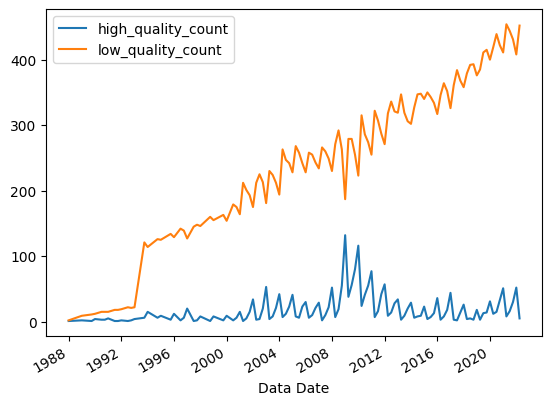

In [271]:
low_avg_count = quality_all[quality_all["ind"] == 0].groupby("Data Date").count()["Ticker"]
high_avg_count = quality_all[quality_all["ind"] == 1].groupby("Data Date").count()[
    "Ticker"]

avg_ret = pd.merge(high_avg_count, low_avg_count,
                   left_index=True, right_index=True)
avg_ret.columns = ["high_quality_count", "low_quality_count"]
avg_ret.plot()

In [273]:
low_avg_ret = quality_all[quality_all["ind"] == 0].groupby("Data Date").mean()["q_ret"]
high_avg_ret = quality_all[quality_all["ind"] == 1].groupby("Data Date").mean()[
    "q_ret"]

avg_ret = pd.merge(high_avg_ret, low_avg_ret, left_index=True, right_index=True)
avg_ret.columns = ["high_quality_avg_ret", "low_quality_avg_ret"]
ave_ret_cum = (avg_ret + 1).cumprod()
ave_ret_cum.columns = ["high_quality_cumprod", "low_quality_cumprod"]
avg_ret_all = pd.merge(avg_ret, ave_ret_cum, left_index=True, right_index=True)
avg_ret_all.to_excel("../clean_data/avg_ret_all.xlsx")

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_15049/787787412.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  low_avg_ret = quality_all[quality_all["ind"] == 0].groupby("Data Date").mean()["q_ret"]
/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_15049/787787412.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  high_avg_ret = quality_all[quality_all["ind"] == 1].groupby("Data Date").mean()[


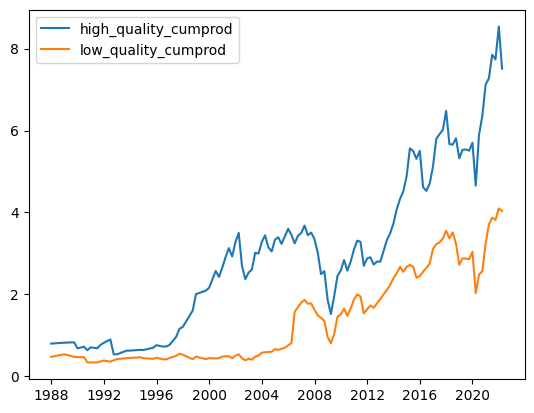

In [277]:
plt.plot(ave_ret_cum)
plt.legend(ave_ret_cum.columns)
plt.savefig("../plot/cumret.png")

/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_15049/411272953.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(avg_ret.iloc[:, 0], rug=True, hist=False)
/var/folders/4r/0rxnv94550vgr87c0xxxdxm40000gn/T/ipykernel_15049/411272953.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe575

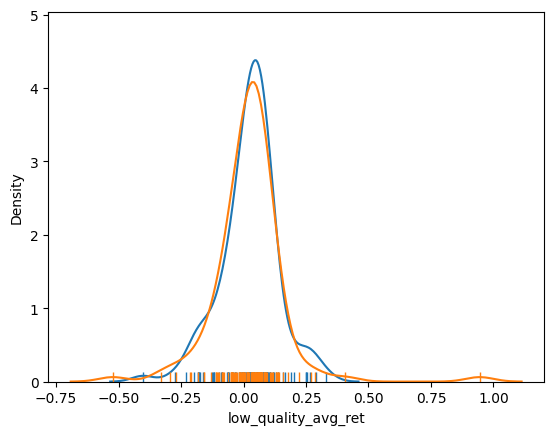

In [263]:
import seaborn as sns
sns.distplot(avg_ret.iloc[:, 0], rug=True, hist=False)
sns.distplot(avg_ret.iloc[:, 1], rug=True, hist=False)
plt.show()

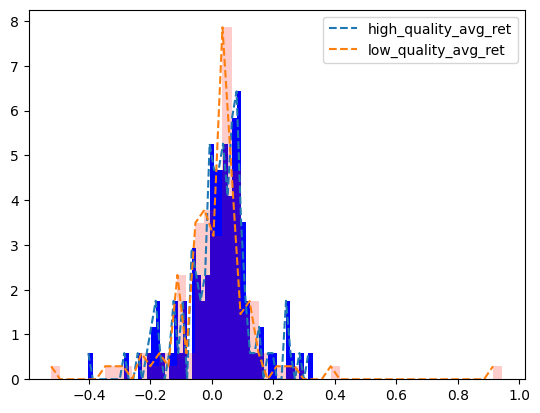

In [267]:
n1, bins1, patches1 = plt.hist(
    avg_ret.iloc[:, 0], bins=50, density=True, color='b', alpha=1)
n2, bins2, patches2 = plt.hist(
    avg_ret.iloc[:, 1], bins=50, density=True, color='r', alpha=0.2)

plt.plot(bins1[:-1],n1,'--')
plt.plot(bins2[:-1],n2,'--')
plt.legend(avg_ret.columns)

plt.savefig("../plot/hist.png")